In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
#from google.colab import drive, files
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers

2024-06-15 06:50:25.408026: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 06:50:25.408202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 06:50:25.579752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [4]:
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='label', ylabel='count'>

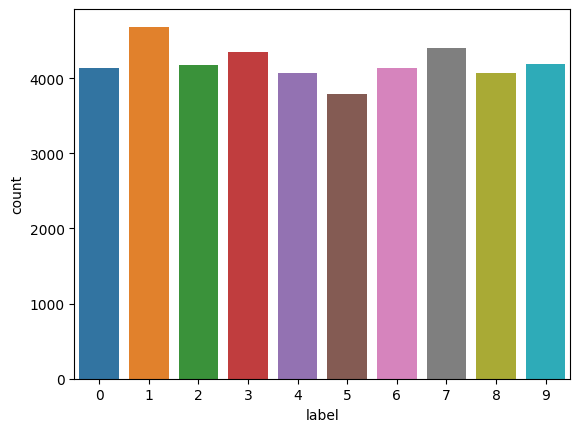

In [6]:
#train['pixel200'].describe()
x_train = train.drop(columns='label')
y_train = train[['label']]
#x_test = test.drop(columns='label')
#y_test = test[['label']]
sns.countplot(y_train,x=y_train['label'])

In [7]:
# check if missings are there
print(x_train.isnull().values.sum())
print(test.isnull().values.sum())

0
0


In [8]:
# cleaning 
x_train = x_train/255.0
x_test = test/255.0

x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

# encode multiclass y label
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)

In [9]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
x_train.shape

(42000, 28, 28, 1)

In [11]:
# Data Splitting
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2, random_state=1000)
print(x_train.shape)
print(x_val.shape)

(33600, 28, 28, 1)
(8400, 28, 28, 1)


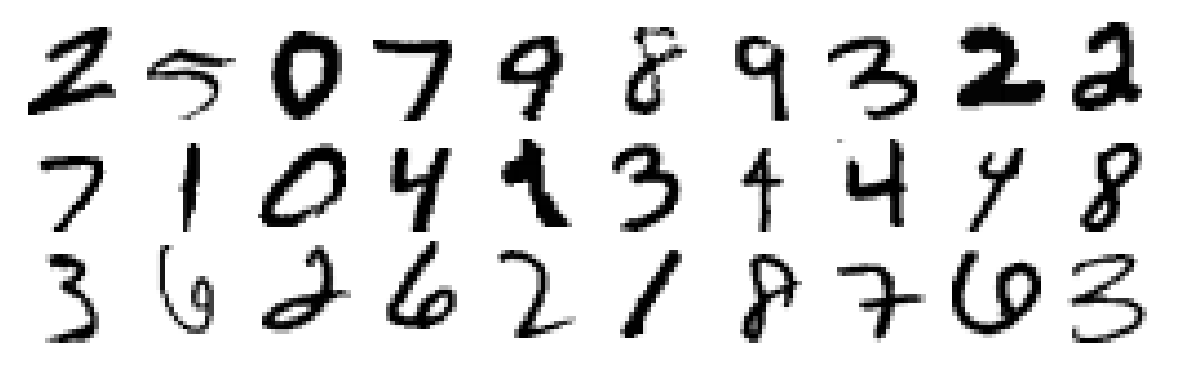

In [12]:
# Preview Images
plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(x_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [13]:
(x_train[i].reshape((28,28))).shape

(28, 28)

In [14]:
x_train[0].reshape(28,28)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
)

train_datagen.fit(x_train)

In [16]:
x_train.shape

(33600, 28, 28, 1)

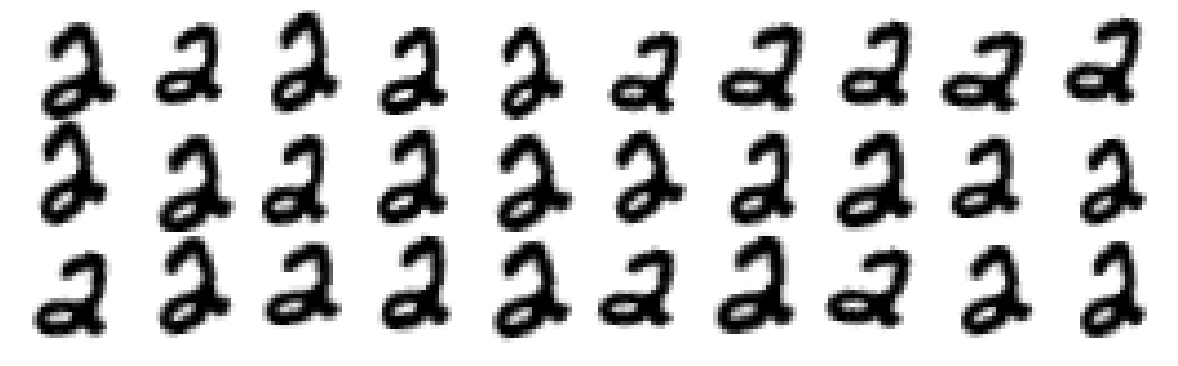

In [17]:
# Preview Augmented Images
x_train3 = x_train[9,].reshape((1,28,28,1))
y_train3 = y_train[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
i=0
for batch in train_datagen.flow(x_train3,y_train3):
    plt.subplot(3, 10, i+1)
    plt.imshow(batch[0][0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: x_train3 = x_train[11,].reshape((1,28,28,1))
    if i==19: x_train3 = x_train[18,].reshape((1,28,28,1))
    i+=1
    if i==30:
        break
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [18]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001,decay_steps=10000,decay_rate=0.9,staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 982,122 (3.75 MB)

 Trainable params: 981,738 (3.75 MB)

 Non-trainable params: 384 (1.50 KB)

In [20]:
batch_size = 82
epochs = 50

history = model.fit(train_datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=early_stop)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


409/409 - 130s - 319ms/step - accuracy: 0.8880 - loss: 2.3933 - val_accuracy: 0.9075 - val_loss: 0.9108
Epoch 2/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


409/409 - 8s - 20ms/step - accuracy: 0.9268 - loss: 0.9537 - val_accuracy: 0.9017 - val_loss: 0.9235
Epoch 3/50
409/409 - 126s - 308ms/step - accuracy: 0.9549 - loss: 0.5226 - val_accuracy: 0.9845 - val_loss: 0.3552
Epoch 4/50
409/409 - 8s - 20ms/step - accuracy: 0.9512 - loss: 0.4121 - val_accuracy: 0.9846 - val_loss: 0.3564
Epoch 5/50
409/409 - 127s - 310ms/step - accuracy: 0.9630 - loss: 0.3890 - val_accuracy: 0.9844 - val_loss: 0.3008
Epoch 6/50
409/409 - 8s - 19ms/step - accuracy: 0.9268 - loss: 0.4566 - val_accuracy: 0.9856 - val_loss: 0.2983
Epoch 7/50
409/409 - 134s - 327ms/step - accuracy: 0.9660 - loss: 0.3658 - val_accuracy: 0.9863 - val_loss: 0.2795
Epoch 8/50
409/409 - 8s - 19ms/step - accuracy: 0.9634 - loss: 0.3322 - val_accuracy: 0.9852 - val_loss: 0.2796
Epoch 9/50
409/409 - 125s - 306ms/step - accuracy: 0.9675 - loss: 0.3314 - val_accuracy: 0.9817 - val_loss: 0.2780
Epoch 10/50
409/409 - 8s - 19ms/step - accuracy: 0.9634 - loss: 0.2918 - val_accuracy: 0.9801 - val_los

In [21]:
results = np.zeros((x_test.shape[0],10))
results = results + model.predict(x_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
#submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
#submission.to_csv("mnist_digit_recognizer.csv",index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step


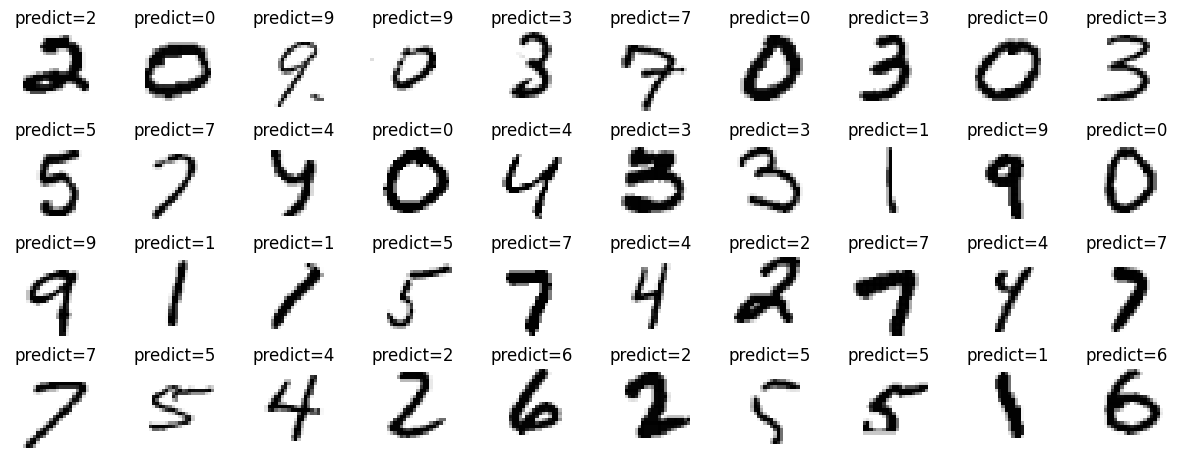

In [22]:
# Preview Predictions
plt.figure(figsize=(15,6))
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(x_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [23]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submission.csv",index=False)
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [24]:
test.shape

(28000, 784)